# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, consult the forums for more troubleshooting tips.**  

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import math
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


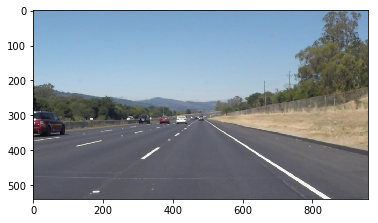

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Test Open Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [3]:
import os
import glob
os.listdir("test_images/")

['solidYellowCurve.jpg',
 'solidYellowLeft.jpg',
 'solidYellowCurve2.jpg',
 'solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'whiteCarLaneSwitch.jpg']

## Display Image Function

In [4]:

def show_images(images, cols=3, save=False, title='Default'):
    cmap = None
    columns = cols
    rows = (len(images)+1)//cols
    
    plt.figure(figsize=(10,12))
    for i,image in enumerate(images):
        plt.subplot(rows,columns, i+1)
        if len(image.shape) == 2:
            cmap = 'gray'
        plt.subplot(rows,cols,i+1)
        plt.imshow(image, cmap=cmap)
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout(pad=0, h_pad=0, w_pad=0)
    if save:
        plt.savefig('image_output/' + title + '.png')
    plt.show()

## Visualise Images

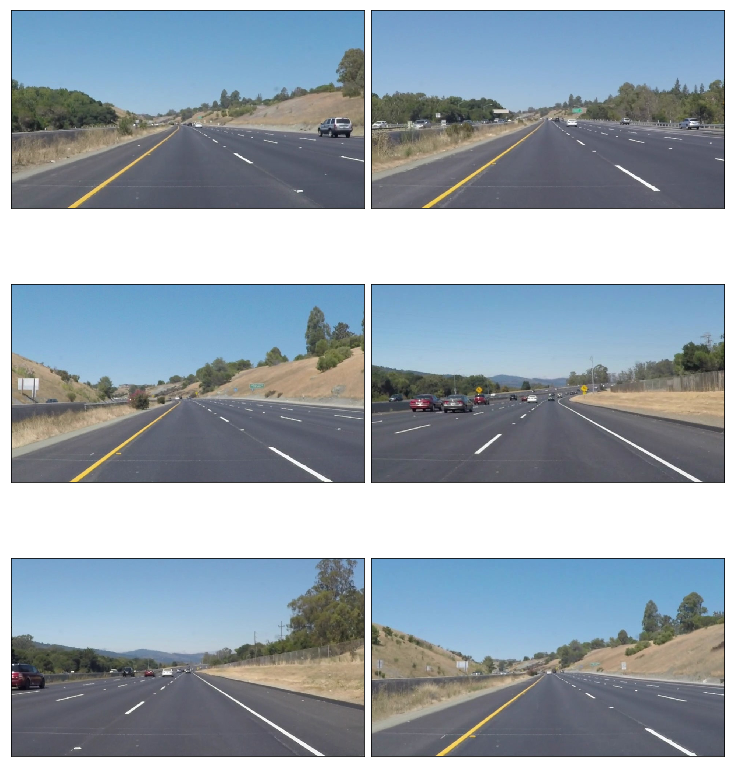

In [5]:
#Create list of input images and print them out
input_images = [mpimg.imread(img_path) for img_path in glob.glob("test_images/*")]

show_images(input_images, cols=2, save=True, title='Inputimages')

# View Grayscale Image

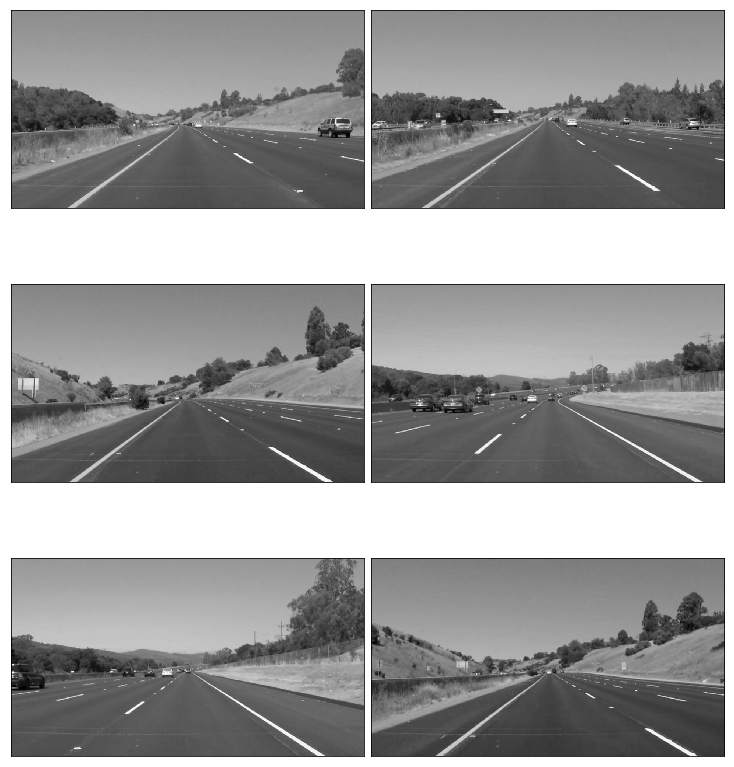

In [6]:
def grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

gray_scale_images = list(map(grayscale, input_images))
show_images(gray_scale_images, cols=2, save=True, title='grayscale_images')

## Gussian Blur Images

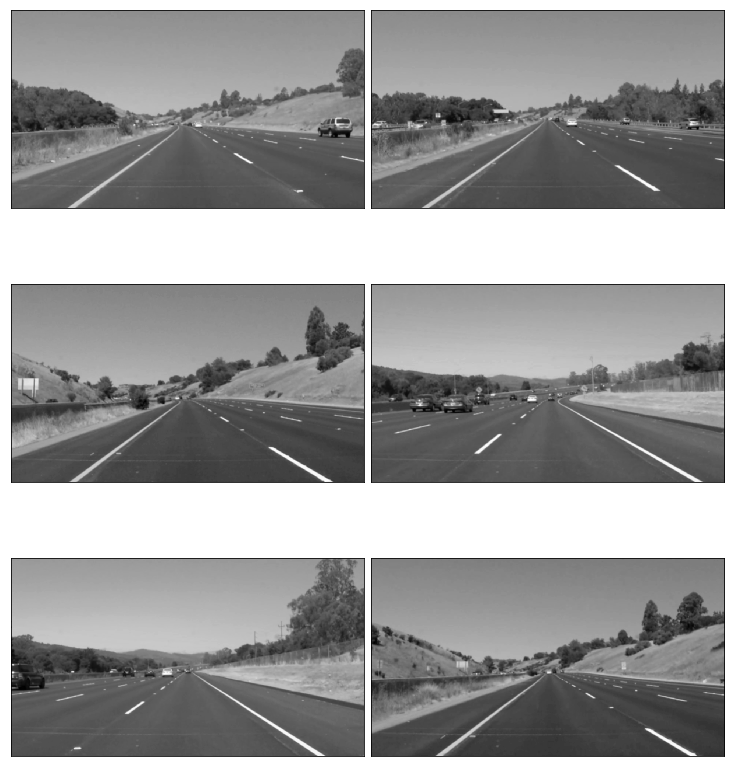

In [7]:
def gaussian_blur(img, kernel_size=5):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

gussian_blur_img = list(map(gaussian_blur, gray_scale_images))
show_images(gussian_blur_img, cols = 2, save=True, title='Gaussian_blur')

## Canny Edge Dection

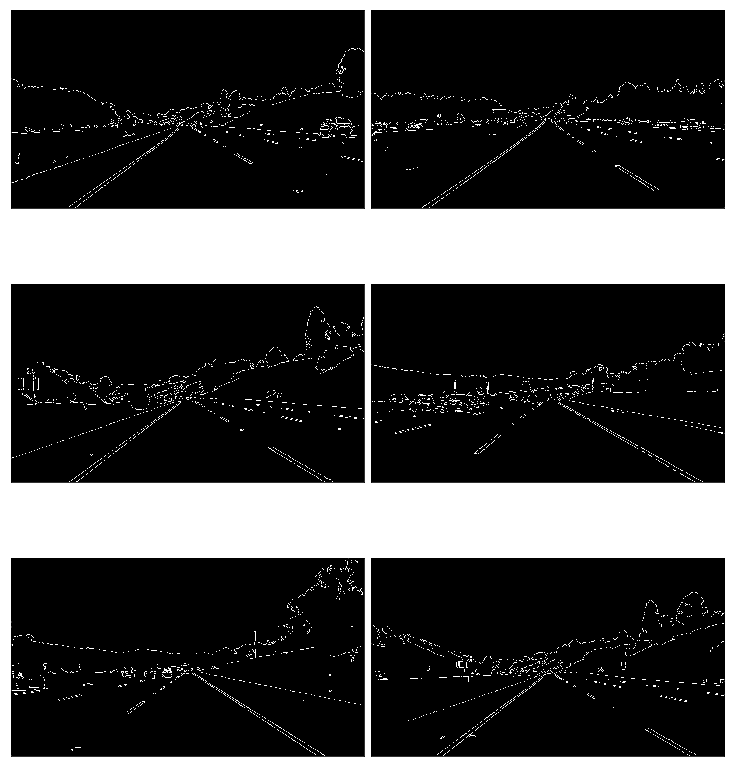

In [8]:
def canny(img, low_threshold = 50, high_threshold = 150):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)


edge_detection = list(map(canny, gussian_blur_img))

show_images(edge_detection, cols =2, save=True, title = 'Canny_edge_image')

## Region of Interest Mask

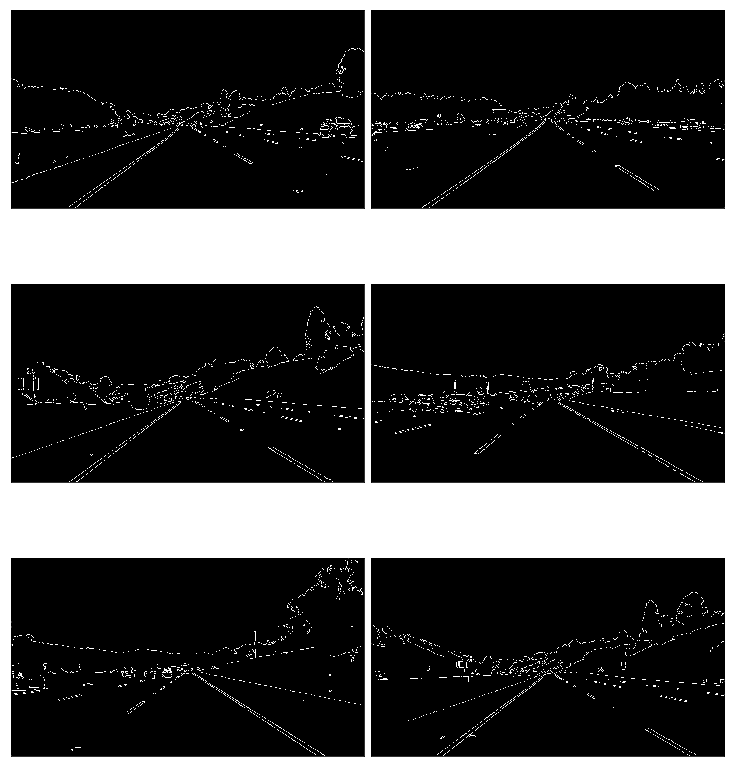

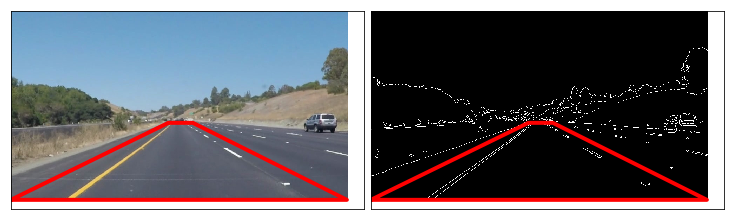

In [9]:
def region_of_interest(img, vertices):
    """
    Applies an image mask.
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def visualise_region(image):
    """
    Function takes a colour image and then gives various regional
    visulisations
    """
    dims = image.shape
    colour_select = np.copy(image)
    line_select = np.copy(image)
    
    grayscale_img = grayscale(image)
    lowpass = gaussian_blur(grayscale_img)
    canny_img = canny(lowpass)
    
    #Define cordinates for region
    left_bottom = [0, dims[0]]
    left_top = [450, 320]
    right_top = [520, 320]
    right_bottom = [dims[1], dims[0]]
    
    #Plot the two region images side by side
    plt.figure(figsize=(10,12))
    #left
    plt.subplot(1,2,1)
    plt.imshow(image)
    x = [left_bottom[0], right_bottom[0], right_top[0], left_top[0] ,left_bottom[0]]
    y = [left_bottom[1], right_bottom[1], right_top[1], left_top[1] ,left_bottom[1]]
    plt.plot(x, y, 'r-', lw=4)
    plt.xticks([])
    plt.yticks([])
    #right
    plt.subplot(1,2,2)
    plt.imshow(canny_img, cmap='gray')
    x = [left_bottom[0], right_bottom[0], right_top[0], left_top[0] ,left_bottom[0]]
    y = [left_bottom[1], right_bottom[1], right_top[1], left_top[1] ,left_bottom[1]]
    plt.plot(x, y, 'r-', lw=4)
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout(pad=0, h_pad=0, w_pad=0)
    plt.savefig('image_output/ROI_vis.png')
    plt.show()
    
    
def region_selection(image):
    
    
    dims = image.shape
    #Define vertices for the region of intrest
    vertices = np.array([[(0,dims[0]),(450, 320),(520, 320),(dims[1], dims[0])]], dtype=np.int32)
    
    return region_of_interest(image, vertices)

ROI_edge_detection = list(map(region_selection, edge_detection))

show_images(edge_detection, cols =2, save=True, title='ROI_canny')
visualise_region(input_images[0])

## Hough Tranform

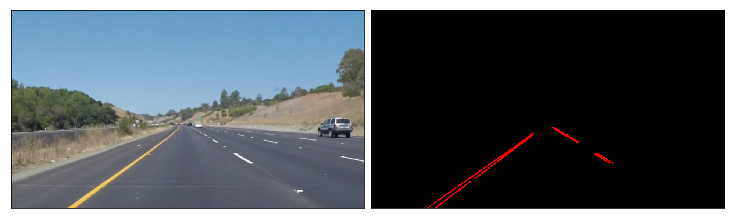

In [10]:
def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines_basic(img, rho=2, theta=np.pi/180, threshold=20, min_line_len=25, max_line_gap=10):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

raw_hough_image = list(map(hough_lines_basic, ROI_edge_detection))

print_items = []
print_items.append(input_images[0])
print_items.append(raw_hough_image[0])
show_images(print_items, cols=2, save=True, title='hough_tranform' )

In [11]:

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)


***
## Build a Lane Finding Pipeline Basic

Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

In [12]:
def lane_line_process(image):
    
    #Reduce image to single grayscale dimension
    gray_image = grayscale(image)
    #get image dimensions
    dims = gray_image.shape
    
    #Set kernel size and apply gaussian smoothing (aka low pass filter)
    kernel_size = 5
    low_pass_image = gaussian_blur(gray_image, kernel_size)
    
    #Define the parameters and apply canny edge detection algorithm
    low_threshold = 50
    high_threshold = 150
    edge_image = canny(low_pass_image, low_threshold, high_threshold)
    
    #Define the vertices and apply a mask to the edge detected image (4sided polygon)
    vertices = np.array([[(0,dims[0]),(450, 320),(520, 320),(dims[1], dims[0])]], dtype=np.int32)
    mask_image = region_of_interest(edge_image, vertices)
    
    #Define paramters and apply hough
    rho = 2 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 20    # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 25 #minimum number of pixels making up a line
    max_line_gap = 10    # maximum gap in pixels between connectable line segments

    image_lines = hough_lines_basic(mask_image, rho, theta, threshold, min_line_length, max_line_gap)
    
    
    final_result = weighted_img(image_lines, image)
    
    return final_result

## Test on Images

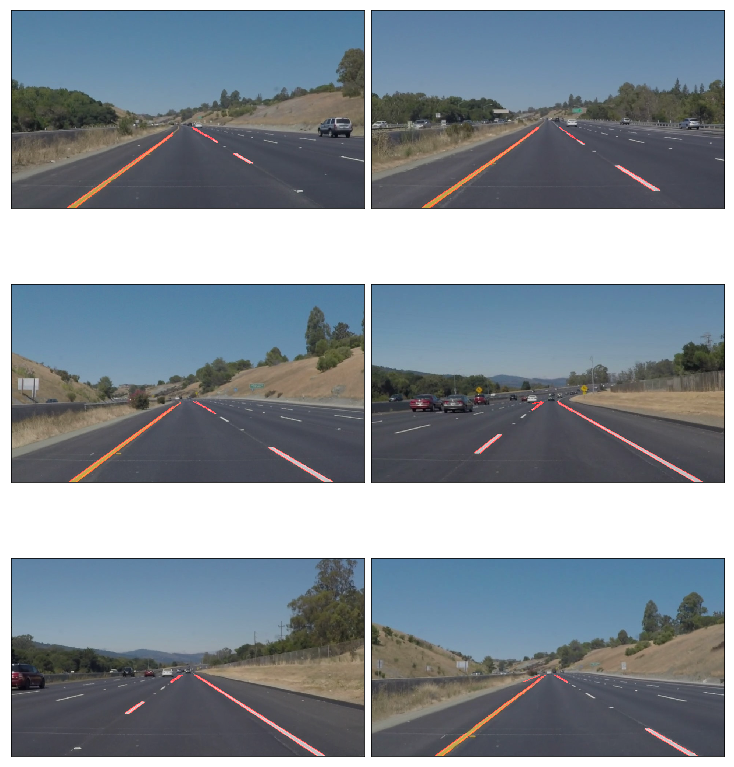

In [13]:
#Apply the lane finding pipeline
detected_lanes = list(map(lane_line_process, input_images))

show_images(detected_lanes, cols = 2, save=True, title='Basic_pipeline')

***
## Build a Lane Finding Pipeline Extended


The pipeline presented so far does quite a good job at identifying lines associated with the lane lines on the road. However there are still some issue with the processing pipeline in its current form.

- Multiple edges are associated with a given lane line

- Some lane lines are only partially recognized

- The design of some lane lines are dashed, therefore the lines need to be interpolated for the system to know there should be lane lines between these dashes.

We now consider how to extend the pipeline to resolve these issues.


- Ultimately what we require is two single lines, one corresponding to each lane line. 

- A suitable approach to achieve this then is to average the gradient and intercept of all identified lines associated with each lane to find two final lane lines. 

- The identified lines from the hough transform can be separated into the associated left and right lane groupings by considering the gradients as they will have opposite signs. 

- We also apply weighting to the averaging by weighting the gradient and intercept of each line by the l2 distance of each line. This is done as longer lines should be more certainly associated with lane line as opposed to small elements of noise in the road.

In [14]:
def line_2_points(y1,y2,line):

    if len(line) != 2:
        return None
    
    gradient, intercept = line
    x1 = int((y1 - intercept)/gradient)
    x2 = int((y2 - intercept)/gradient)
    y1 = int(y1)
    y2 = int(y2)
    
    return((x1,y1), (x2,y2))
    
    
            
def draw_lane_lines(img, lines, color=[255, 0, 0], thickness=15):
    
    #Use function to find the average line from 
    #esemble of lines from the hough transform
    left_line, right_line = calculate_average_lines(lines)
    
    #Want the lane lanes to extend from the bottom of the image
    #to a set amount in the y dimension
    start_lane_line = img.shape[0]
    end_lane_line = img.shape[0]*0.6
    
    left_lane = line_2_points(start_lane_line, end_lane_line, left_line)
    right_lane = line_2_points(start_lane_line, end_lane_line, right_line)
    
    #Draw the two lanes
    cv2.line(img, *left_lane, color, thickness)
    cv2.line(img, *right_lane, color, thickness)
    
       
    
def calculate_average_lines(lines):
    
    left_lane_lines = []
    left_line_distances = []
    right_lane_lines = []
    right_line_distances = []
    
    for i,line in enumerate(lines):
        for x1,y1,x2,y2 in line:
            if (x1==x2 or y1==y2):
                #If we incounter a horiztonal or vertical line
                #then continue to next iteration
                continue
            #Calcuate attributes of the line
            gradient = (y2-y1)/(x2-x1)
            intercept = y2 - gradient*x2
            l2_distance = np.sqrt((y2-y1)**2 + (x2-x1)**2)
            
            if gradient > 0:
                right_lane_lines.append((gradient, intercept))
                right_line_distances.append(l2_distance)
            else:
                left_lane_lines.append((gradient, intercept))
                left_line_distances.append(l2_distance)
                
            
    right_sum_dis = np.sum(right_line_distances)
    left_sum_dis = np.sum(left_line_distances)
            
    right_line_distances = np.asarray(right_line_distances)
    right_line_distances = np.asarray(right_line_distances)
    
    weights_right = right_line_distances / right_sum_dis
    weights_left = left_line_distances / left_sum_dis
    
    average_right_lane = np.dot(weights_right, right_lane_lines)
    average_left_lane = np.dot(weights_left, left_lane_lines)
    
    return average_left_lane, average_right_lane
                
def hough_lines_extended(img, rho=2, theta=np.pi/180, threshold=20, min_line_len=25, max_line_gap=10):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lane_lines(line_img, lines)
    return line_img


def lane_line_process_extended(image):
    
    #Reduce image to single grayscale dimension
    gray_image = grayscale(image)
    #get image dimensions
    dims = gray_image.shape
    
    #Set kernel size and apply gaussian smoothing (aka low pass filter)
    kernel_size = 5
    low_pass_image = gaussian_blur(gray_image, kernel_size)
    
    #Define the parameters and apply canny edge detection algorithm
    low_threshold = 50
    high_threshold = 150
    edge_image = canny(low_pass_image, low_threshold, high_threshold)
    
    #Define the vertices and apply a mask to the edge detected image (4sided polygon)
    vertices = np.array([[(0,dims[0]),(450, 320),(520, 320),(dims[1], dims[0])]], dtype=np.int32)
    mask_image = region_of_interest(edge_image, vertices)
    
    #Define paramters and apply hough
    rho = 2 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 20    # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 25 #minimum number of pixels making up a line
    max_line_gap = 10    # maximum gap in pixels between connectable line segments

    image_lines = hough_lines_extended(mask_image, rho, theta, threshold, min_line_length, max_line_gap)
    
    
    final_result = weighted_img(image_lines, image)
    
    return final_result


## Test on Images

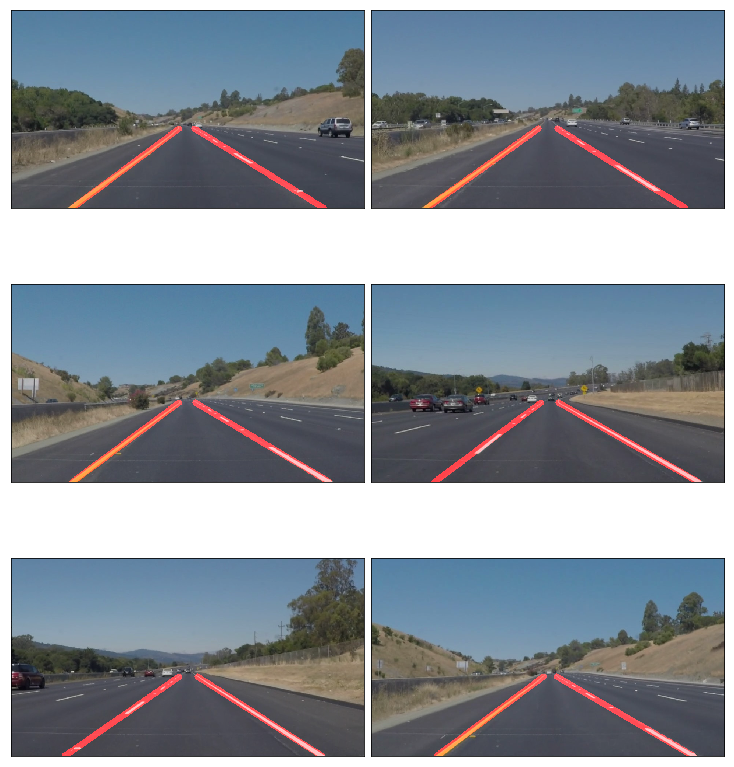

In [15]:
#Apply the lane finding pipeline
detected_lanes = list(map(lane_line_process_extended, input_images))

show_images(detected_lanes, cols = 2, save=True, title='Extended_pipeline')

***
## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an import error when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel). Still have problems? Try relaunching Jupyter Notebook from the terminal prompt. Also, consult the forums for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) for more troubleshooting tips across operating systems.**

In [16]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [17]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    result = lane_line_process_extended(image)
    return result

Let's try the one with the solid white lane on the right first ...

In [18]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)


[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|█████████▉| 221/222 [00:14<00:00, 14.82it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 36.6 s, sys: 1.48 s, total: 38.1 s
Wall time: 16.1 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [19]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [20]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


100%|█████████▉| 681/682 [00:50<00:00, 13.47it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

CPU times: user 2min 13s, sys: 4.3 s, total: 2min 17s
Wall time: 51.5 s


In [21]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [22]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4


100%|██████████| 251/251 [00:33<00:00,  5.52it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

CPU times: user 1min 11s, sys: 2.64 s, total: 1min 14s
Wall time: 35.4 s


In [23]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))